In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
plt.ioff()
import h5py
import pandas as pd
from tqdm.notebook import tqdm
from skimage.measure import block_reduce
import scipy.ndimage
from PIL import Image


In [2]:
f = h5py.File("data_files/nue_WithWire_00.h5")

wire_table_rse_num_tups = np.array(f['wire_table']['event_id'], dtype=np.uint64)
particle_table_rse_num_tups = np.array(f['particle_table']['event_id'], dtype=np.uint64)

wire_table_rse_nums = wire_table_rse_num_tups[:, 0] * 1_000_000_000_000 + wire_table_rse_num_tups[:, 1] * 1_000_000 + wire_table_rse_num_tups[:, 2]
particle_table_rse_nums = particle_table_rse_num_tups[:, 0] * 1_000_000_000_000 + particle_table_rse_num_tups[:, 1] * 1_000_000 + particle_table_rse_num_tups[:, 2]

unique_rse_nums = np.unique(wire_table_rse_nums)


rm: cannot remove 'event_display_images_lores/*.png': No such file or directory


  0%|          | 0/2 [00:00<?, ?it/s]

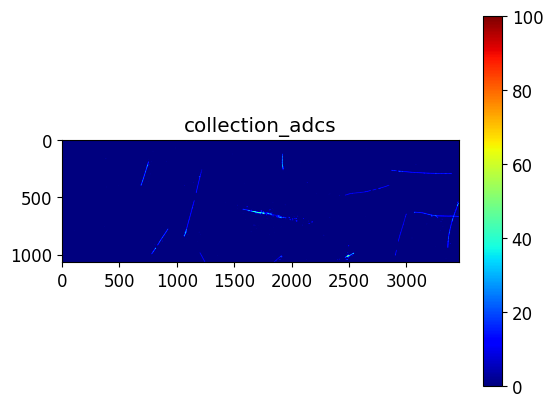

scaling_z=0.3, scaling_x=0.342
collection_adcs.shape=(3456, 1067)
scaled_arr.shape=(365, 1037)
nu_vtx_z=np.float64(471.9), nu_vtx_x=np.float32(208.20044)


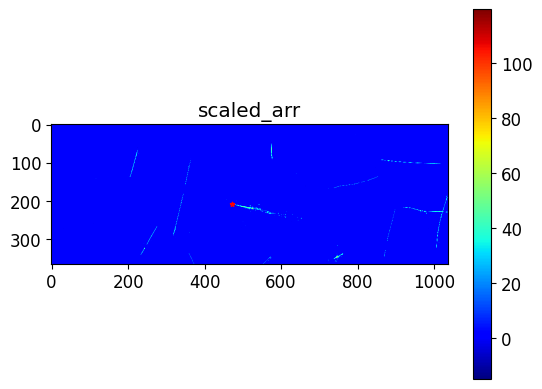

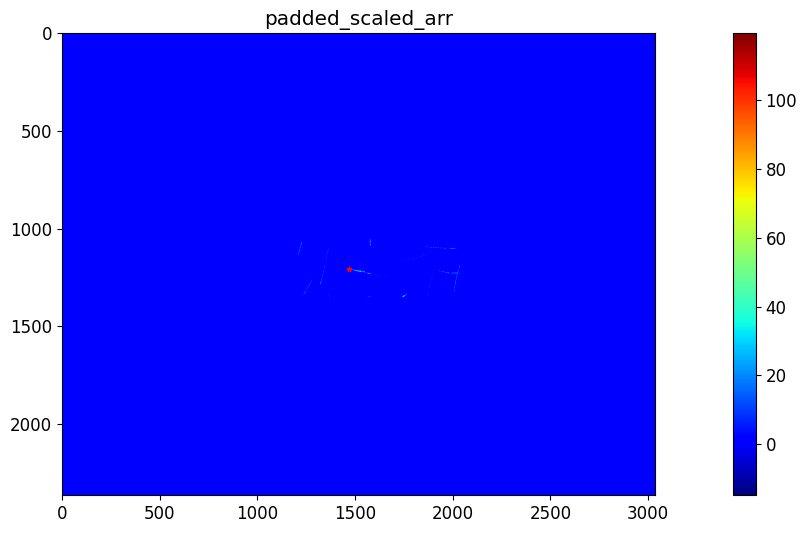

nu_vtx_index_z=1471, nu_vtx_index_x=1208
padded_scaled_arr.shape=(2365, 3037)
image_arr.shape=(128, 128)


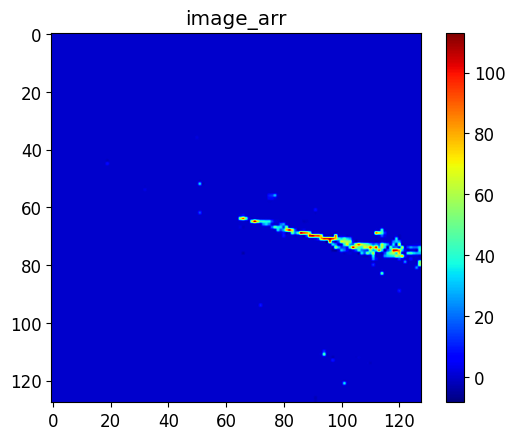

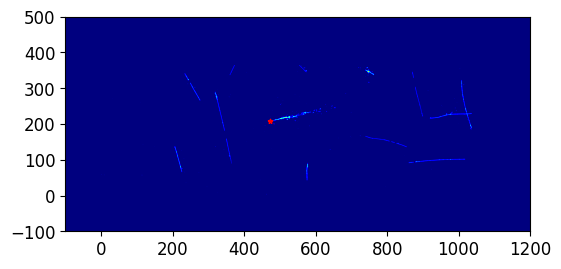

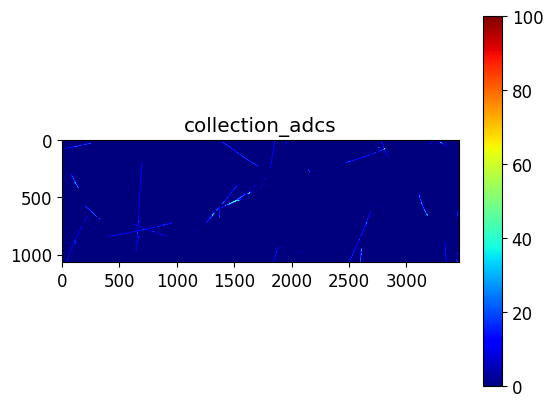

scaling_z=0.3, scaling_x=0.342
collection_adcs.shape=(3456, 1067)
scaled_arr.shape=(365, 1037)
nu_vtx_z=np.float64(409.2), nu_vtx_x=np.float32(207.8318)


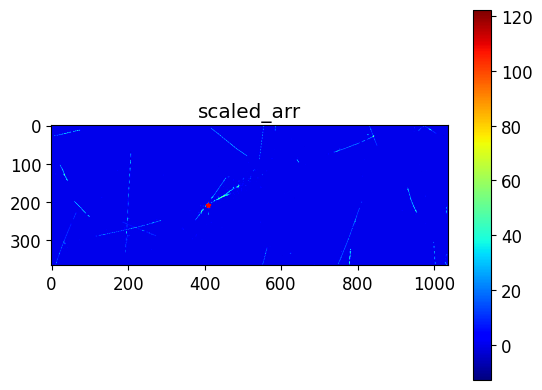

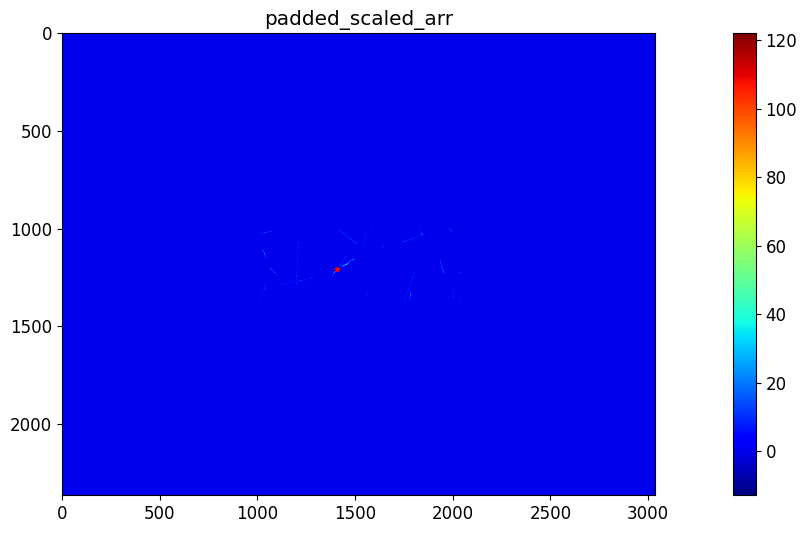

nu_vtx_index_z=1409, nu_vtx_index_x=1207
padded_scaled_arr.shape=(2365, 3037)
image_arr.shape=(128, 128)


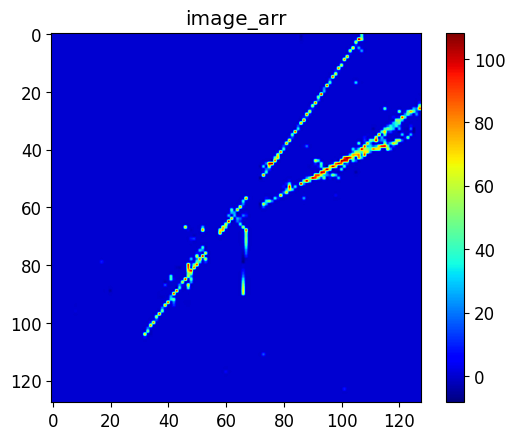

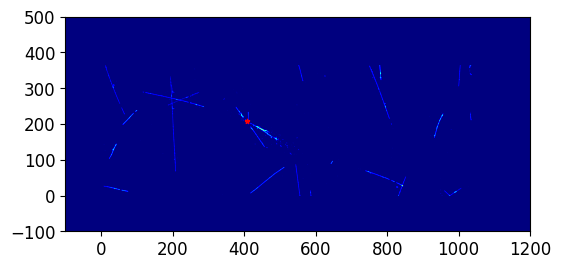

In [16]:
all_adcs = f['wire_table']['adc']
all_local_wires = f['wire_table']['local_wire']
all_local_planes = f['wire_table']['local_plane']

particle_start_wire_pos = f['particle_table']['start_wire_pos']
particle_start_wire_time = f['particle_table']['start_wire_time']

os.system("rm event_display_images_hires/*.png")
os.system("rm event_display_images_lores/*.png")

num_events = 2
for event_i in tqdm(range(num_events)):

    curr_rse_num = unique_rse_nums[event_i]
    curr_run_num = int(curr_rse_num // 1_000_000_000_000)
    curr_subrun_num = int((curr_rse_num % 1_000_000_000_000) // 1_000_000)
    curr_event_num = int(curr_rse_num % 1_000_000)

    # Only looking at first particle to get neutrino vertex info, for some reason the vertex from the event_table tree didn't seem to match.
    event_particle_start_wire_pos = np.array(particle_start_wire_pos[particle_table_rse_nums == unique_rse_nums[event_i]])[0]
    event_particle_start_wire_time = np.array(particle_start_wire_time[particle_table_rse_nums == unique_rse_nums[event_i]])[0]

    event_adcs = np.array(all_adcs[wire_table_rse_nums == unique_rse_nums[event_i]])
    event_local_wire_nums = np.array(all_local_wires[wire_table_rse_nums == unique_rse_nums[event_i]]).flatten()
    event_local_plane_nums = np.array(all_local_planes[wire_table_rse_nums == unique_rse_nums[event_i]]).flatten()

    collection_adcs = event_adcs[event_local_plane_nums == 2]
    collection_local_wire_nums = event_local_wire_nums[event_local_plane_nums == 2]
    collection_particle_start_wire_pos = event_particle_start_wire_pos[2]
    collection_particle_start_wire_time = event_particle_start_wire_time[0]

    wire_pitch = 0.3 # cm, from https://microboone.fnal.gov/wp-content/uploads/MICROBOONE-NOTE-1083-PUB.pdf
    time_tick = 0.5 # microseconds, from https://microboone.fnal.gov/wp-content/uploads/MICROBOONE-NOTE-1083-PUB.pdf
    drift_velocity = 0.114 # cm / microsecond # 114 cm / millisecond, from https://microboone.fnal.gov/wp-content/uploads/MICROBOONE-NOTE-1026-PUB.pdf

    nu_vtx_z = collection_particle_start_wire_pos * wire_pitch # measuring from leftmost wire, not exactly the same as detector coordinates!
    nu_vtx_x = collection_particle_start_wire_time * time_tick * drift_velocity # approximate and relative, not exactly the same as detector coordinates!

    f_downsample = 6
    collection_adcs = block_reduce(collection_adcs, block_size=(1, f_downsample), func=np.sum)

    adccutoff = 10.*f_downsample/6.
    adcsaturation = 100.*f_downsample/6.
    collection_adcs[collection_adcs < adccutoff] = 0
    collection_adcs[collection_adcs > adcsaturation] = adcsaturation
    # this is the standard form of ADCs, from the public data reference notebook

    plt.figure()
    plt.imshow(collection_adcs.T, cmap='jet')
    plt.colorbar()
    plt.title("collection_adcs")
    plt.show()

    scaling_z = wire_pitch
    scaling_x = time_tick * f_downsample * drift_velocity

    print(f"{scaling_z=}, {scaling_x=}")
    print(f"{collection_adcs.shape=}")

    scaled_arr = scipy.ndimage.zoom(collection_adcs, (scaling_z, scaling_x)).T

    print(f"{scaled_arr.shape=}")

    print(f"{nu_vtx_z=}, {nu_vtx_x=}")

    plt.figure()
    plt.imshow(scaled_arr, cmap='jet')
    plt.colorbar()
    plt.scatter(nu_vtx_z, nu_vtx_x, c='red', s=10, marker='*')
    plt.title("scaled_arr")
    plt.show()

    num_pad_pixels = 1000
    
    padded_scaled_arr = np.pad(scaled_arr, ((num_pad_pixels, num_pad_pixels), (num_pad_pixels, num_pad_pixels)), mode='constant', constant_values=0)

    plt.figure(figsize=(20, 6))
    plt.imshow(padded_scaled_arr, cmap='jet')
    plt.colorbar()
    plt.scatter(nu_vtx_z + num_pad_pixels, nu_vtx_x + num_pad_pixels, c='red', s=10, marker='*')
    plt.title("padded_scaled_arr")
    plt.show()

    resolution = 128

    nu_vtx_index_z = int(nu_vtx_z) + num_pad_pixels
    nu_vtx_index_x = int(nu_vtx_x) + num_pad_pixels

    print(f"{nu_vtx_index_z=}, {nu_vtx_index_x=}")

    image_arr = padded_scaled_arr[nu_vtx_index_x - resolution // 2 : nu_vtx_index_x + resolution // 2, 
                                  nu_vtx_index_z - resolution // 2 : nu_vtx_index_z + resolution // 2]
    
    print(f"{padded_scaled_arr.shape=}")
    print(f"{image_arr.shape=}")

    plt.figure()
    plt.imshow(image_arr, cmap='jet')
    plt.colorbar()
    plt.title("image_arr")
    plt.show()

    extents = [0, collection_adcs.shape[0] * wire_pitch, 0, collection_adcs.shape[1] * time_tick * f_downsample * drift_velocity]

    # making a plot, in order to let us get the image at different resolutions
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()
    plt.imshow(np.zeros((100, 100)), cmap='jet', extent=[-10000, 10000, -10000, 10000]) # missing background is blue, in case the neutrino is near the edge when we crop it
    plt.imshow(collection_adcs.T, origin='lower', cmap='jet', extent=extents)
    plt.scatter(nu_vtx_z, nu_vtx_x, c='red', s=10, marker='*')
    plt.xlim(-100, 1200)
    plt.ylim(-100, 500)
    if event_i < 20: plt.savefig(f"event_display_images_hires/event_{event_i:06d}.png", pad_inches=0, dpi=600) # saving a few hi-res images
    plt.show()
    #plt.savefig(f"event_display_images_lores/event_{event_i:06d}.png", pad_inches=0, dpi=128)
    #plt.close(fig)


In [4]:
# making gifs, just for visualization purposes

images = []
for event_i in range(5):
    images.append(imageio.imread(f"event_display_images_hires/event_{event_i:06d}.png"))
imageio.mimsave('event_displays_hires.gif', images, loop=0, duration=100)

images = []
for event_i in range(5):
    images.append(imageio.imread(f"event_display_images_lores/event_{event_i:06d}.png"))
imageio.mimsave('event_displays_lores.gif', images, loop=0, duration=100)



/tmp/ipykernel_49279/2373235062.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"event_display_images_hires/event_{event_i:06d}.png"))


FileNotFoundError: No such file: '/home/lee/ml_projects/lartpc_image_pca/event_display_images_hires/event_000002.png'

In [6]:
images = []
for event_i in range(num_events):
    img = Image.open(f"event_display_images_lores/event_{event_i:06d}.png")
    img_array = np.array(img)
    images.append(img_array)

np.savez("processed_data_files/nue_images.npz", lores_images=np.stack(images))

#data = np.load("processed_data_files/nue_images.npz")


In [7]:
images[0].shape

(128, 128, 4)